# Preprocessing The Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

C:\Users\noorh\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
file_path_y = r"C:\Users\noorh\OneDrive\Desktop\Uni\Grad Project\HMC Dataset\A4C.xlsx"
df_y = pd.read_excel(file_path_y)

# Convert 'non-MI' to 0 and 'MI' to 1 in the SEG columns
for col in ['SEG1', 'SEG2', 'SEG3', 'SEG5', 'SEG6', 'SEG7']:
    df_y[col] = df_y[col].apply(lambda x: 0 if x == 'non-MI' else 1 if x == 'MI' else x)

# Load the motion feature vectors
file_path_x = r"C:\Users\noorh\Echocardiograms\Final Submission\motion_features.xlsx"
df_x = pd.read_excel(file_path_x)

# Remove the "Mask_" prefix from 'Sub-directory Name' to match with ECHO in df_y
#df_x['subdirectory'] = df_x['subdirectory'].str.replace('Mask_', '')


merged_df = pd.merge(df_y, df_x, left_on='ECHO', right_on='subdirectory')

X_columns = ['segment1', 'segment2', 'segment3', 'segment5', 'segment6', 'segment7']
y_columns = ['SEG1', 'SEG2', 'SEG3', 'SEG5', 'SEG6', 'SEG7']

X = merged_df[X_columns]
y = merged_df[y_columns]

# Create a single binary target column
y['target'] = y.max(axis=1)

# Normalize the features to unity
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y['target'], test_size=0.2, random_state=42)

C:\Users\noorh\AppData\Local\Temp\ipykernel_14580\2728707460.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['target'] = y.max(axis=1)


In [8]:
def plot_confusion_matrices(conf_matrix_train, conf_matrix_test):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-MI', 'MI'], yticklabels=['Non-MI', 'MI'], ax=ax[0])
    ax[0].set_title('Training Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-MI', 'MI'], yticklabels=['Non-MI', 'MI'], ax=ax[1])
    ax[1].set_title('Testing Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')
    
    plt.show()

def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = f1_score(y_true, y_pred)

    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", conf_matrix)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("F1 Score:", f1)
    
    return conf_matrix

# Decision Tree Classifier

Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        27
           1       0.98      0.96      0.97        56

    accuracy                           0.96        83
   macro avg       0.96      0.96      0.96        83
weighted avg       0.96      0.96      0.96        83

Confusion Matrix:
 [[26  1]
 [ 2 54]]
Accuracy: 0.963855421686747
Precision: 0.9818181818181818
Sensitivity (Recall): 0.9642857142857143
Specificity: 0.9629629629629629
F1 Score: 0.972972972972973
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.86      0.86      0.86        14

    accuracy                           0.81        21
   macro avg       0.79      0.7

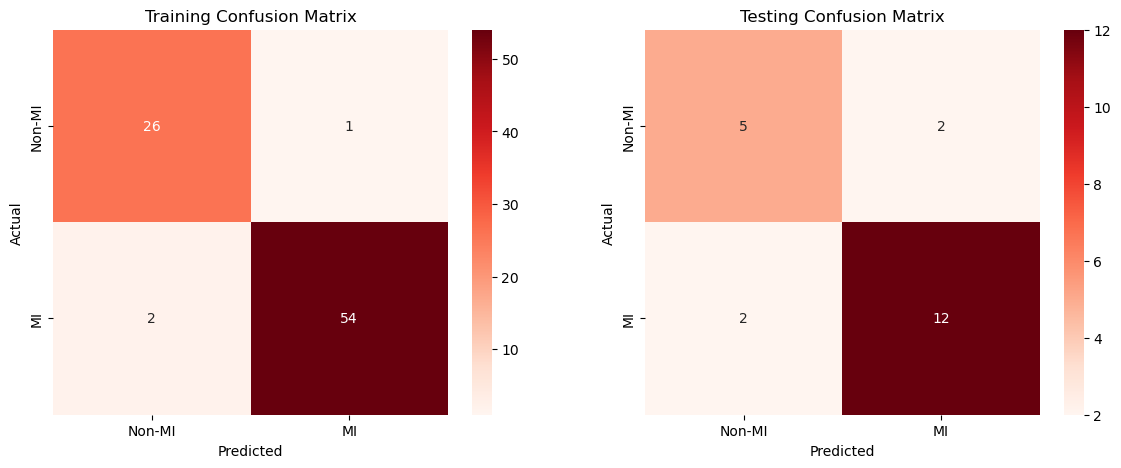

In [9]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

# Training predictions and metrics
y_train_pred = best_model.predict(X_train)
conf_matrix_train = calculate_metrics(y_train, y_train_pred)

# Testing predictions and metrics
y_test_pred = best_model.predict(X_test)
conf_matrix_test = calculate_metrics(y_test, y_test_pred)

# Plot confusion matrices side by side
plot_confusion_matrices(conf_matrix_train, conf_matrix_test)

# SVM Classifier

Best parameters found:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77        27
           1       0.88      0.91      0.89        56

    accuracy                           0.86        83
   macro avg       0.84      0.83      0.83        83
weighted avg       0.85      0.86      0.85        83

Confusion Matrix:
 [[20  7]
 [ 5 51]]
Accuracy: 0.8554216867469879
Precision: 0.8793103448275862
Sensitivity (Recall): 0.9107142857142857
Specificity: 0.7407407407407407
F1 Score: 0.8947368421052632
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21

Confusion Matrix:
 [[ 6  1

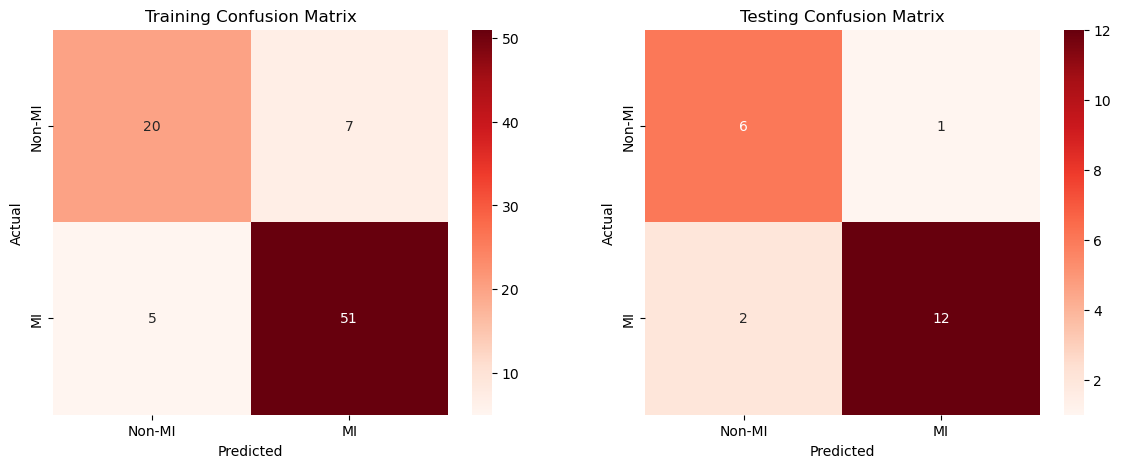

In [10]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

clf = SVC(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

# Training predictions and metrics
y_train_pred = best_model.predict(X_train)
conf_matrix_train = calculate_metrics(y_train, y_train_pred)

# Testing predictions and metrics
y_test_pred = best_model.predict(X_test)
conf_matrix_test = calculate_metrics(y_test, y_test_pred)

# Plot confusion matrices side by side
plot_confusion_matrices(conf_matrix_train, conf_matrix_test)

# Logistic Regression Classifier

Best parameters found:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77        27
           1       0.86      0.96      0.91        56

    accuracy                           0.87        83
   macro avg       0.88      0.82      0.84        83
weighted avg       0.87      0.87      0.86        83

Confusion Matrix:
 [[18  9]
 [ 2 54]]
Accuracy: 0.8674698795180723
Precision: 0.8571428571428571
Sensitivity (Recall): 0.9642857142857143
Specificity: 0.6666666666666666
F1 Score: 0.9075630252100839
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21

Confusion Matrix:
 [[ 6  1

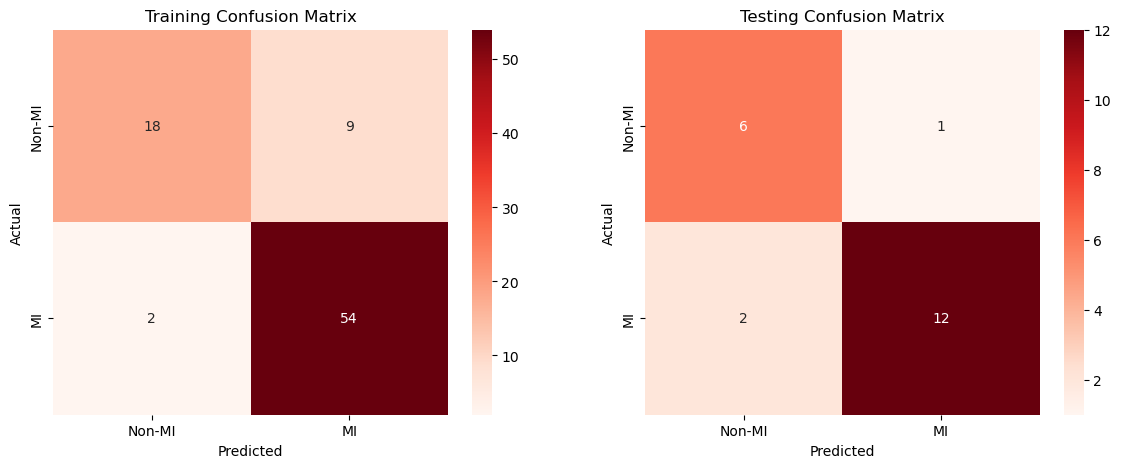

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf = LogisticRegression(random_state=42, max_iter=10000)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

# Training predictions and metrics
y_train_pred = best_model.predict(X_train)
conf_matrix_train = calculate_metrics(y_train, y_train_pred)

# Testing predictions and metrics
y_test_pred = best_model.predict(X_test)
conf_matrix_test = calculate_metrics(y_test, y_test_pred)

# Plot confusion matrices side by side
plot_confusion_matrices(conf_matrix_train, conf_matrix_test)

# KNN Classifier 

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        27
           1       0.86      1.00      0.93        56

    accuracy                           0.89        83
   macro avg       0.93      0.83      0.86        83
weighted avg       0.91      0.89      0.88        83

Confusion Matrix:
 [[18  9]
 [ 0 56]]
Accuracy: 0.891566265060241
Precision: 0.8615384615384616
Sensitivity (Recall): 1.0
Specificity: 0.6666666666666666
F1 Score: 0.9256198347107438
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.79      0.79      0.79        14

    accuracy                           0.71        21
   macro avg       0.68      0.68      0.68        21
weighted avg       0.71      0.71      0.71        21

Confusion Matrix:
 [[ 4  3]

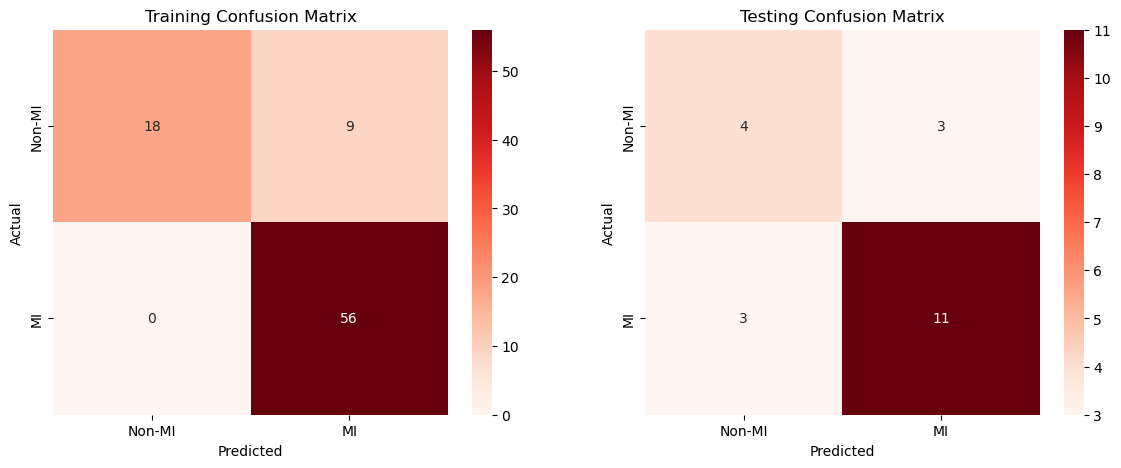

In [12]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

clf = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

# Training predictions and metrics
y_train_pred = best_model.predict(X_train)
conf_matrix_train = calculate_metrics(y_train, y_train_pred)

# Testing predictions and metrics
y_test_pred = best_model.predict(X_test)
conf_matrix_test = calculate_metrics(y_test, y_test_pred)

# Plot confusion matrices side by side
plot_confusion_matrices(conf_matrix_train, conf_matrix_test)

# Random Forest Classifier

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       0.98      0.98      0.98        56

    accuracy                           0.98        83
   macro avg       0.97      0.97      0.97        83
weighted avg       0.98      0.98      0.98        83

Confusion Matrix:
 [[26  1]
 [ 1 55]]
Accuracy: 0.9759036144578314
Precision: 0.9821428571428571
Sensitivity (Recall): 0.9821428571428571
Specificity: 0.9629629629629629
F1 Score: 0.9821428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.87      0.93      0.90        14

    accuracy                           0.86        21
   macro avg       0.85      0.82      0.83        21


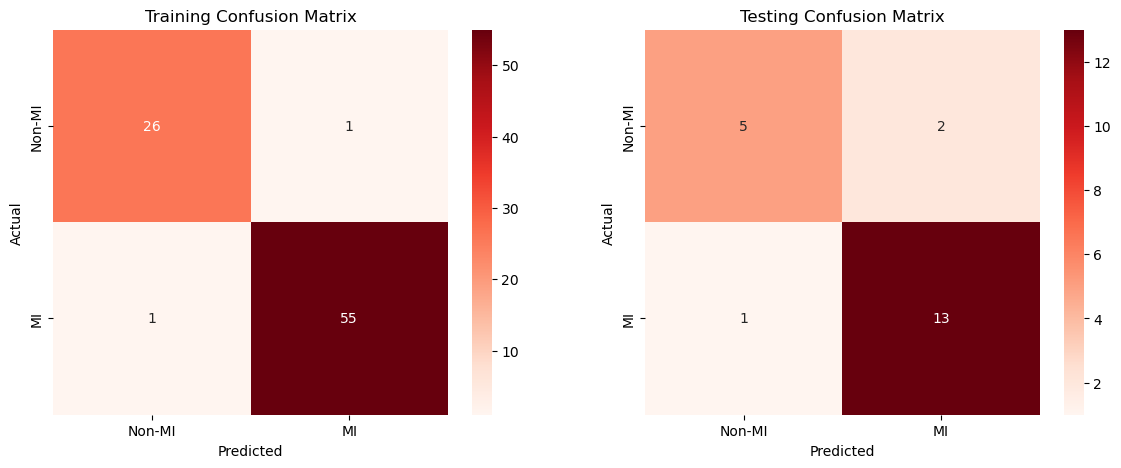

In [13]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

# Training predictions and metrics
y_train_pred = best_model.predict(X_train)
conf_matrix_train = calculate_metrics(y_train, y_train_pred)

# Testing predictions and metrics
y_test_pred = best_model.predict(X_test)
conf_matrix_test = calculate_metrics(y_test, y_test_pred)

# Plot confusion matrices side by side
plot_confusion_matrices(conf_matrix_train, conf_matrix_test)